In [98]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.7.1
torchvision: 0.8.2
numpy: 1.19.4
scikit-learn: 0.24.0
Using device:  cpu


In [11]:
# specify learning params
batch_size = 264
learning_rate = 1e-3
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


In [131]:
def train_model(model, batch_size, learning_rate, epochs, data, data_percent, train, device, with_gf=False):
    print(f"Training {model.name} started...")
    model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:
        # data_limit = int(len(data) * data_percent)
        # print(f"Number of train images: {data_limit}")
        print(f"Number of train images: {len(data)}")

        # trainloader = torch.utils.data.DataLoader(data[:data_limit],
        trainloader = torch.utils.data.DataLoader(data,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  drop_last=False)

        model = model.fit(trainloader=trainloader, epochs=epochs, start_lr=learning_rate, device=device, model_path=pretrained_model_path, with_gf=with_gf)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model

### SimCLR Transforms example

In [13]:
t = SimCLRTransforms(with_original=True)

In [14]:
data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <models.simclr.transforms.SimCLRTransforms object at 0x139c22a30>

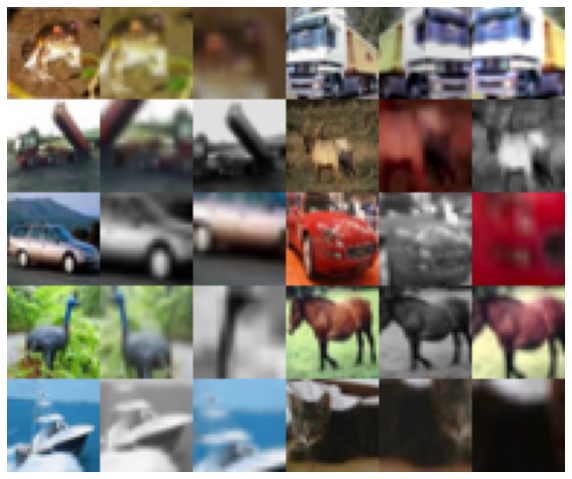

In [15]:
t_pic = []
for i in range(10):
    pic = torch.from_numpy(np.transpose(data.data[i], (2,0,1)))
    t_pic.extend(list(t(pic)))
plot_images(t_pic, nrow=6)

### Gradient flow

In [228]:
model = SimCLR(resnet_model='resnet18')

Files already downloaded and verified
Training SimCLR started...
Number of train images: 20000
SimCLR: Epoch 1/1 - Iteration 76 - Train loss:5.2632, LR: 0.001


SimCLR(
  (base_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

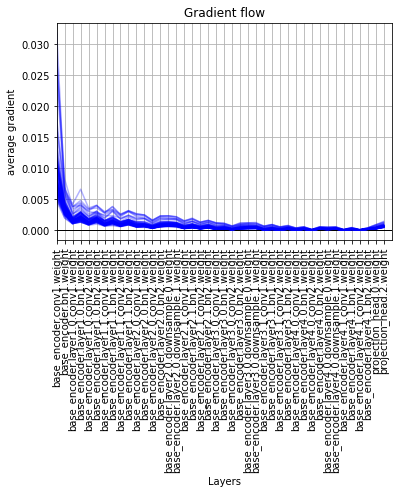

In [229]:
gradient_data = load_util.load_custom_cifar('./data', download=True, for_model='SimCLR', data_percent=0.4)
train_model(model, batch_size, learning_rate, 1, gradient_data, data_percent, train, device, with_gf=True)

### Clustering and PCA of the Random SimCLR model

In [5]:
def encode_batchwise(dataloader, model, device):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        vec, proj = model(batch_data)
        embeddings.append(vec.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels

In [6]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [77]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

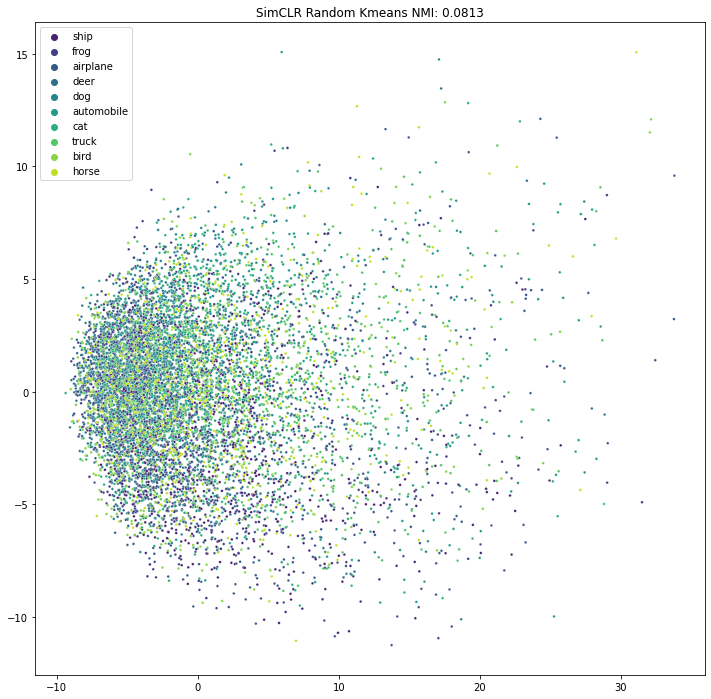

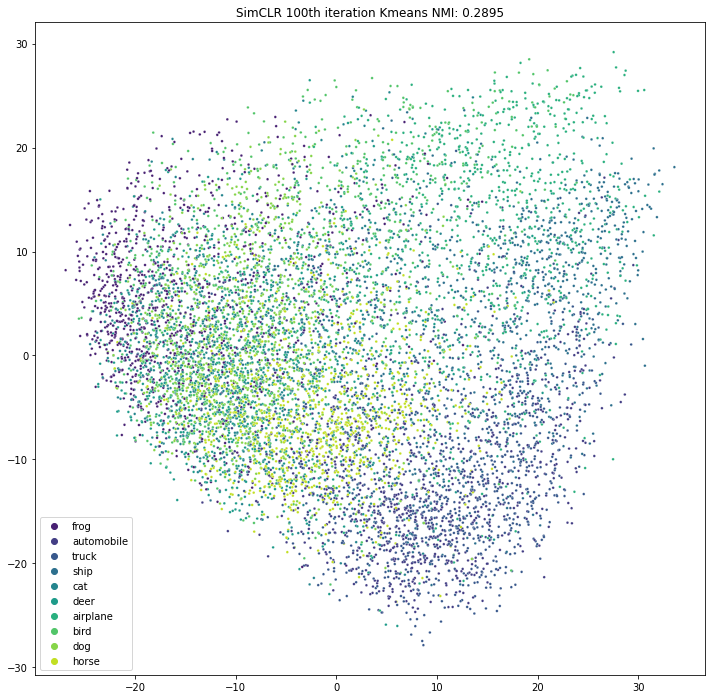

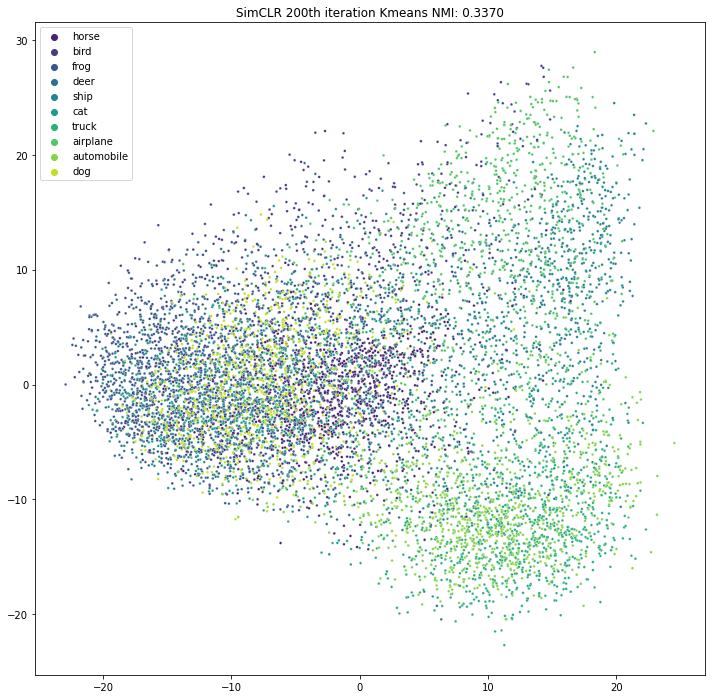

In [93]:
for i in range(3):
    model = SimCLR(resnet_model='resnet18')
    ver = 'Random'
    
    if i > 0:
        state_dict = torch.load(f'trained_models/pretrained_SimCLR_{i}00.pth', map_location='cpu')
        model.load_state_dict(state_dict)
        ver = f'{i}00th iteration'
        
    embedded_data, labels = encode_batchwise(testloader, model, device)
    lable_classes=[colors_classes[l] for l in labels]
    
    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title(f'SimCLR {ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

### Loss statistics

In [103]:
epochs = pd.read_csv("stats/epoch_stat.csv", delimiter=',')
iteration = pd.read_csv("stats/iteration_stat.csv", delimiter=',')

In [104]:
epochs.head()

,epoch,iteration,loss
0,0,79,3.4439
1,1,158,3.2944
2,2,237,3.3587
3,3,316,3.0839
4,4,395,3.3050


In [105]:
iteration.head()

,epoch,iteration,loss
0,0,1,6.1647
1,0,2,6.1435
2,0,3,5.9987
3,0,4,5.9607
4,0,5,5.8656


<AxesSubplot:title={'center':'(final) loss over 100 epochs'}, xlabel='epoch'>

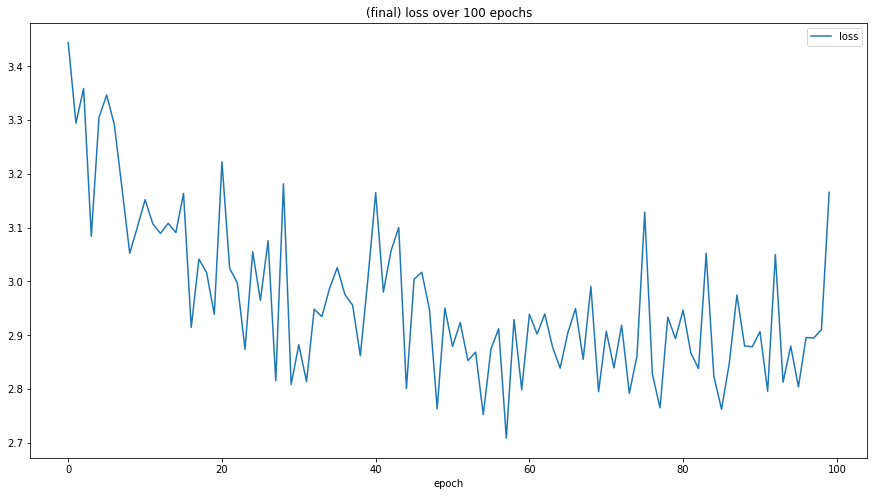

In [100]:
epochs.plot(x='epoch', y='loss', kind='line',figsize=(15,8), title='(final) loss over 100 epochs')

<AxesSubplot:title={'center':'Loss during the 0th epoch'}, xlabel='iteration'>

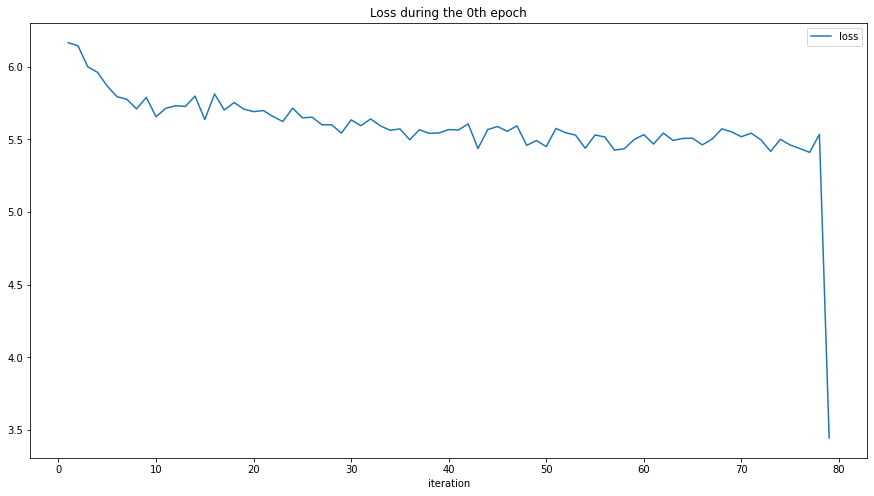

In [106]:
iteration[iteration.epoch==0].plot(x='iteration', y='loss', kind='line',figsize=(15,8),title='Loss during the 0th epoch')

<AxesSubplot:title={'center':'Loss over the first 5 epochs'}, xlabel='iteration'>

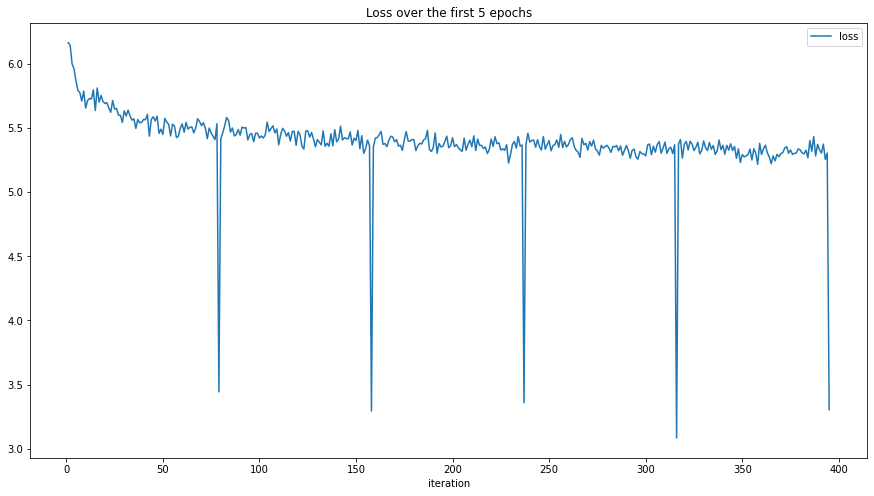

In [109]:
iteration[iteration.epoch<5].plot(x='iteration', y='loss', kind='line',figsize=(15,8),title='Loss over the first 5 epochs')

This trend of loss being minimal at the end of the epoch continues over the whole training

In [121]:
it_epoch_group = iteration.groupby("epoch")["loss"].mean()

Text(0.5, 1.0, 'Average loss over 100 epochs (real scale)')

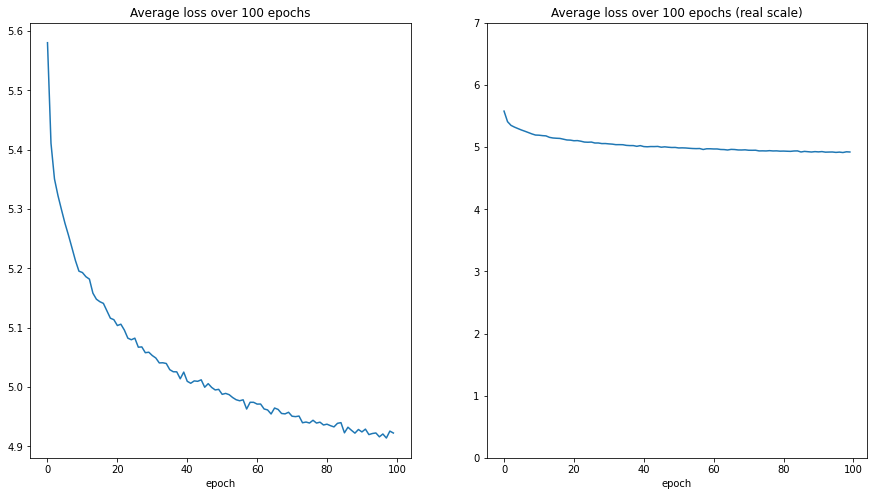

In [123]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
it_epoch_group.plot(ax = axes[0], subplots=True, x='epoch', y='loss', kind='line')
axes[0].set_title('Average loss over 100 epochs')
it_epoch_group.plot(ax = axes[1], subplots=True, x='epoch', y='loss', kind='line', ylim=(0,7))
axes[1].set_title('Average loss over 100 epochs (real scale)')